# Brain Tumor Detection - Training Notebook

This notebook trains a ResNet18 model on brain MRI images to classify tumors into 4 categories:
- Glioma
- Meningioma
- No Tumor
- Pituitary

**Training will use local GPU if available.**

## 1. Setup and Imports

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All imports successful!")

All imports successful!


## 2. Set Random Seeds for Reproducibility

In [2]:
def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False  # Allow non-deterministic for speed
    torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner for best performance
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random seed set to {seed}")
    print(f"cuDNN benchmark enabled for GPU optimization")

set_seed(42)

Random seed set to 42
cuDNN benchmark enabled for GPU optimization


## 3. GPU Detection and Device Configuration

In [3]:
# Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"✅ GPU DETECTED")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print(f"❌ NO GPU DETECTED - Using CPU (very slow!)")
    print(f"\nYour RTX 2060 is not being used!")
    print(f"\nTo fix this, run in PowerShell terminal:")
    print(f"  pip uninstall torch torchvision torchaudio")
    print(f"  pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")
    print(f"\nThen restart the notebook kernel.")

Using device: cuda
PyTorch version: 2.5.1+cu121
✅ GPU DETECTED
GPU Name: NVIDIA GeForce RTX 2060
GPU Memory: 6.00 GB
CUDA Version: 12.1


## 4. Configuration and Hyperparameters

In [4]:
# Project paths (relative)
PROJECT_ROOT = Path('..')
DATA_DIR = PROJECT_ROOT / 'data'
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
MODEL_DIR = PROJECT_ROOT / 'models'
OUTPUT_DIR = PROJECT_ROOT / 'outputs'

# Create directories if they don't exist
MODEL_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

# Hyperparameters
CONFIG = {
    'batch_size': 128,  # Increased to better saturate RTX 2060 (6GB VRAM)
    'num_epochs': 10,
    'learning_rate': 0.001,
    'img_size': 224,
    'num_workers': 2,  # Parallel data loading to reduce CPU bottleneck
    'model_name': 'tumor_model.pth',
    'metrics_name': 'metrics.json'
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  batch_size: 128
  num_epochs: 10
  learning_rate: 0.001
  img_size: 224
  num_workers: 2
  model_name: tumor_model.pth
  metrics_name: metrics.json


## 5. Data Preprocessing and Augmentation

In [5]:
# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

print("Data transforms configured:")
print("  Training: Resize, Flip, Rotation, ColorJitter, Normalize")
print("  Validation: Resize, Normalize")

Data transforms configured:
  Training: Resize, Flip, Rotation, ColorJitter, Normalize
  Validation: Resize, Normalize


## 6. Load Dataset

In [6]:
# Load datasets using ImageFolder (auto-infers classes from folder names)
train_dataset = datasets.ImageFolder(root=str(TRAIN_DIR), transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root=str(TEST_DIR), transform=data_transforms['test'])

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if CONFIG['num_workers'] > 0 else False  # Keep workers alive between epochs
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if CONFIG['num_workers'] > 0 else False
)

# Get class names and number of classes
class_names = train_dataset.classes
num_classes = len(class_names)

print(f"\nDataset loaded successfully!")
print(f"  Classes detected: {class_names}")
print(f"  Number of classes: {num_classes}")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(test_dataset)}")

print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(test_loader)}")


Dataset loaded successfully!
  Classes detected: ['glioma', 'meningioma', 'notumor', 'pituitary']
  Number of classes: 4
  Training samples: 5712
  Validation samples: 1311
  Training batches: 45
  Validation batches: 11


## 7. Visualize Sample Images

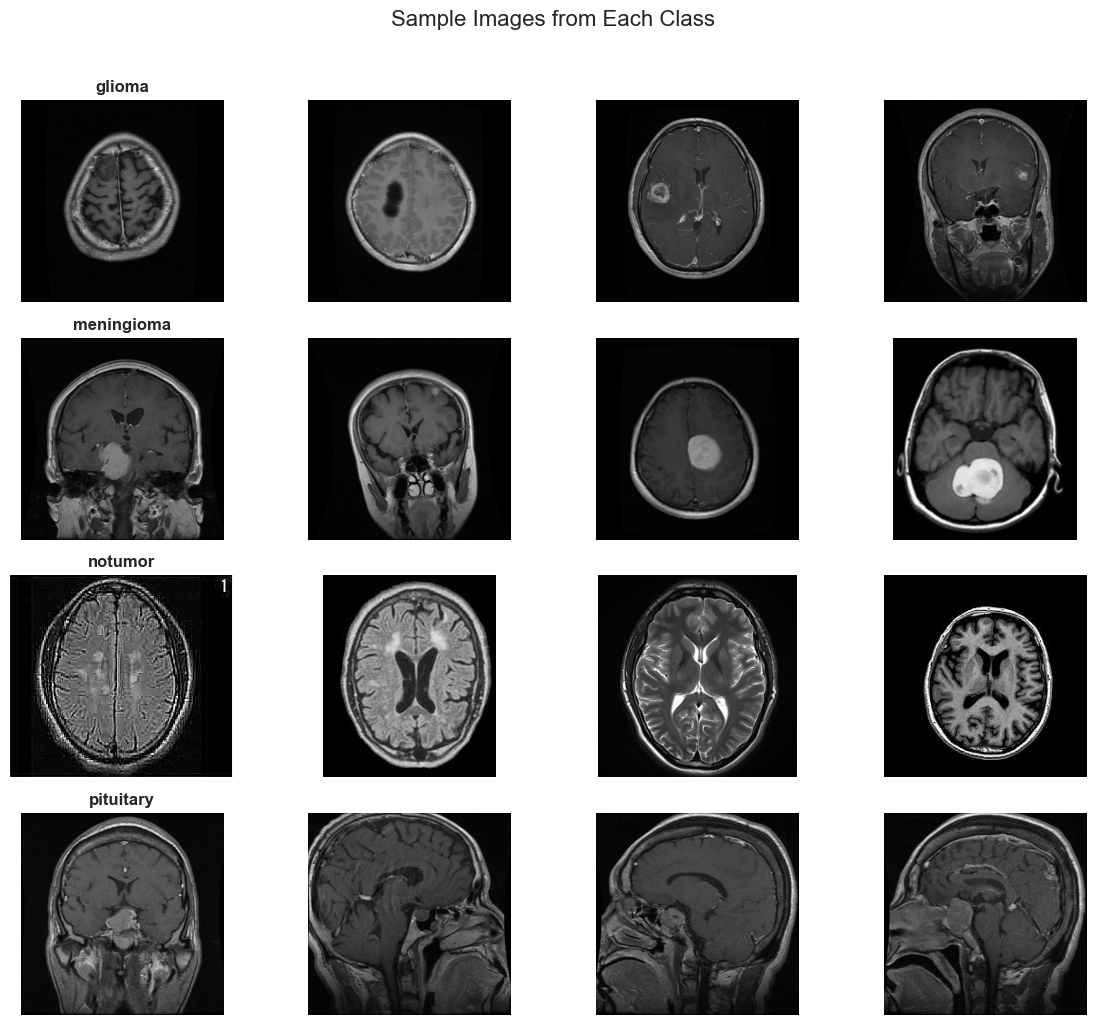

In [7]:
# Display sample images from each class
def show_sample_images(dataset, class_names, num_samples=4):
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(12, 10))
    fig.suptitle('Sample Images from Each Class', fontsize=16, y=1.02)
    
    for class_idx, class_name in enumerate(class_names):
        # Get indices for this class
        class_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]
        # Sample random images
        sample_indices = random.sample(class_indices, min(num_samples, len(class_indices)))
        
        for i, idx in enumerate(sample_indices):
            img_path = dataset.samples[idx][0]
            img = Image.open(img_path).convert('RGB')
            
            axes[class_idx, i].imshow(img)
            axes[class_idx, i].axis('off')
            if i == 0:
                axes[class_idx, i].set_title(f'{class_name}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

show_sample_images(train_dataset, class_names)

## 8. Build Model (ResNet18)

In [8]:
# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Modify final fully connected layer for our number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Move model to GPU
model = model.to(device)

print(f"Model: ResNet18")
print(f"  Input features to FC layer: {num_features}")
print(f"  Output classes: {num_classes}")
print(f"  Model loaded on: {device}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

d:\Jash\Personal Projects\Python\brain-tumor-detection2\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Jash\Personal Projects\Python\brain-tumor-detection2\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model: ResNet18
  Input features to FC layer: 512
  Output classes: 4
  Model loaded on: cuda
  Total parameters: 11,178,564
  Trainable parameters: 11,178,564


## 9. Define Loss Function and Optimizer

In [9]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

# Learning rate scheduler (optional but recommended)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

print("Training setup:")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: Adam")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Scheduler: ReduceLROnPlateau")

Training setup:
  Loss function: CrossEntropyLoss
  Optimizer: Adam
  Learning rate: 0.001
  Scheduler: ReduceLROnPlateau


## 10. Training Loop

In [10]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Enable mixed precision training for faster GPU training
    scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else None
    
    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        if scaler is not None:
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Use mixed precision for validation too
            if torch.cuda.is_available():
                with torch.amp.autocast('cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


print("Training and validation functions defined (with mixed precision for GPU speedup).")

Training and validation functions defined (with mixed precision for GPU speedup).


## 11. Train the Model

In [11]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Best model tracking
best_val_acc = 0.0
best_model_path = MODEL_DIR / CONFIG['model_name']

print(f"\nStarting training for {CONFIG['num_epochs']} epochs...\n")

for epoch in range(CONFIG['num_epochs']):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, test_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'class_names': class_names
        }, best_model_path)
        print(f"  ✓ New best model saved! (Val Acc: {val_acc*100:.2f}%)")

print(f"\n{'='*60}")
print("Training completed!")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
print(f"Model saved to: {best_model_path}")
print(f"{'='*60}")


Starting training for 10 epochs...


Epoch 1/10


Validation: 100%|██████████| 11/11 [00:27<00:00,  2.47s/it, loss=0.5149, acc=83.22%]



Epoch 1 Summary:
  Train Loss: 0.3192 | Train Acc: 87.92%
  Val Loss:   0.6403 | Val Acc:   83.22%
  ✓ New best model saved! (Val Acc: 83.22%)

Epoch 2/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.84it/s, loss=0.5615, acc=83.37%]



Epoch 2 Summary:
  Train Loss: 0.1296 | Train Acc: 95.36%
  Val Loss:   0.4041 | Val Acc:   83.37%
  ✓ New best model saved! (Val Acc: 83.37%)

Epoch 3/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.78it/s, loss=0.1388, acc=94.51%]



Epoch 3 Summary:
  Train Loss: 0.0755 | Train Acc: 97.62%
  Val Loss:   0.1575 | Val Acc:   94.51%
  ✓ New best model saved! (Val Acc: 94.51%)

Epoch 4/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.73it/s, loss=0.0713, acc=91.38%]



Epoch 4 Summary:
  Train Loss: 0.0862 | Train Acc: 96.95%
  Val Loss:   0.2672 | Val Acc:   91.38%

Epoch 5/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.71it/s, loss=0.6312, acc=94.74%]



Epoch 5 Summary:
  Train Loss: 0.0638 | Train Acc: 97.78%
  Val Loss:   0.1547 | Val Acc:   94.74%
  ✓ New best model saved! (Val Acc: 94.74%)

Epoch 6/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.69it/s, loss=0.0211, acc=96.03%]



Epoch 6 Summary:
  Train Loss: 0.0538 | Train Acc: 98.11%
  Val Loss:   0.1257 | Val Acc:   96.03%
  ✓ New best model saved! (Val Acc: 96.03%)

Epoch 7/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.52it/s, loss=0.0107, acc=97.41%]



Epoch 7 Summary:
  Train Loss: 0.0416 | Train Acc: 98.49%
  Val Loss:   0.0722 | Val Acc:   97.41%
  ✓ New best model saved! (Val Acc: 97.41%)

Epoch 8/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.79it/s, loss=0.0197, acc=97.94%]



Epoch 8 Summary:
  Train Loss: 0.0441 | Train Acc: 98.63%
  Val Loss:   0.0493 | Val Acc:   97.94%
  ✓ New best model saved! (Val Acc: 97.94%)

Epoch 9/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s, loss=0.1329, acc=97.10%]



Epoch 9 Summary:
  Train Loss: 0.0410 | Train Acc: 98.48%
  Val Loss:   0.1007 | Val Acc:   97.10%

Epoch 10/10


Validation: 100%|██████████| 11/11 [00:02<00:00,  4.80it/s, loss=0.0017, acc=97.94%]


Epoch 10 Summary:
  Train Loss: 0.0362 | Train Acc: 98.74%
  Val Loss:   0.0483 | Val Acc:   97.94%

Training completed!
Best validation accuracy: 97.94%
Model saved to: ..\models\tumor_model.pth


## 12. Plot Training History

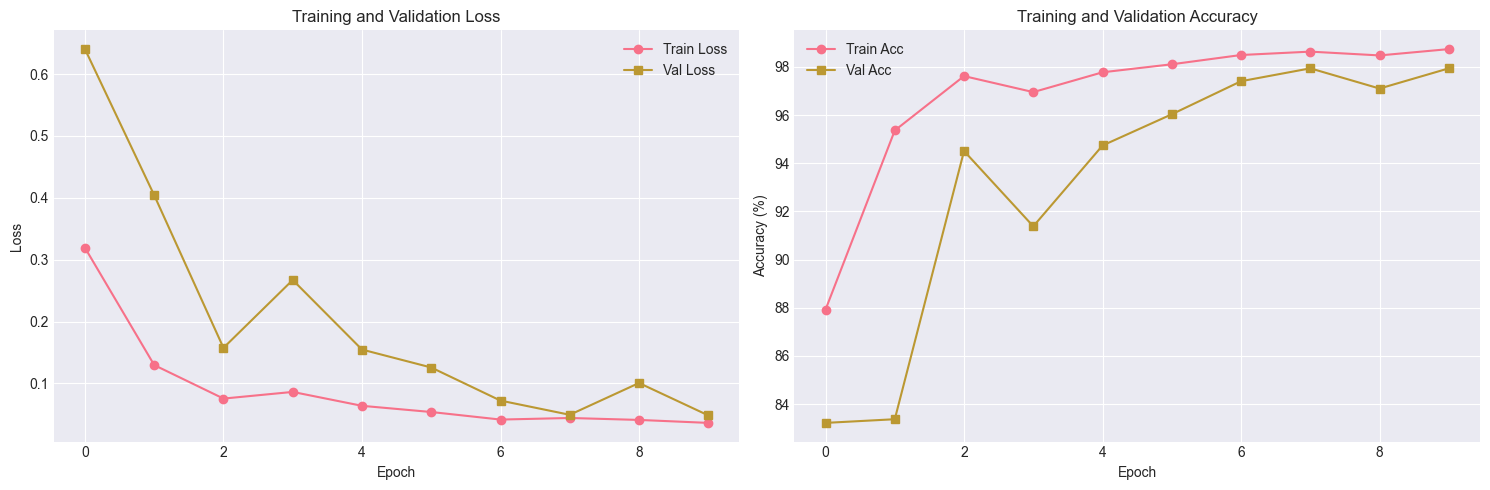

Training history plot saved to: ..\outputs\training_history.png


In [12]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot([acc*100 for acc in history['train_acc']], label='Train Acc', marker='o')
ax2.plot([acc*100 for acc in history['val_acc']], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training history plot saved to: {OUTPUT_DIR / 'training_history.png'}")

## 13. Load Best Model and Evaluate

In [13]:
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']}")
print(f"Best validation accuracy: {checkpoint['val_acc']*100:.2f}%")

Loaded best model from epoch 8
Best validation accuracy: 97.94%


C:\Users\neelr\AppData\Local\Temp\ipykernel_2180\1751975456.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


## 14. Generate Predictions for Evaluation

In [14]:
# Get predictions on validation set
all_preds = []
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Generating predictions'):
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f"Generated predictions for {len(all_preds)} samples")

Generating predictions: 100%|██████████| 11/11 [00:04<00:00,  2.48it/s]

Generated predictions for 1311 samples


## 15. Confusion Matrix

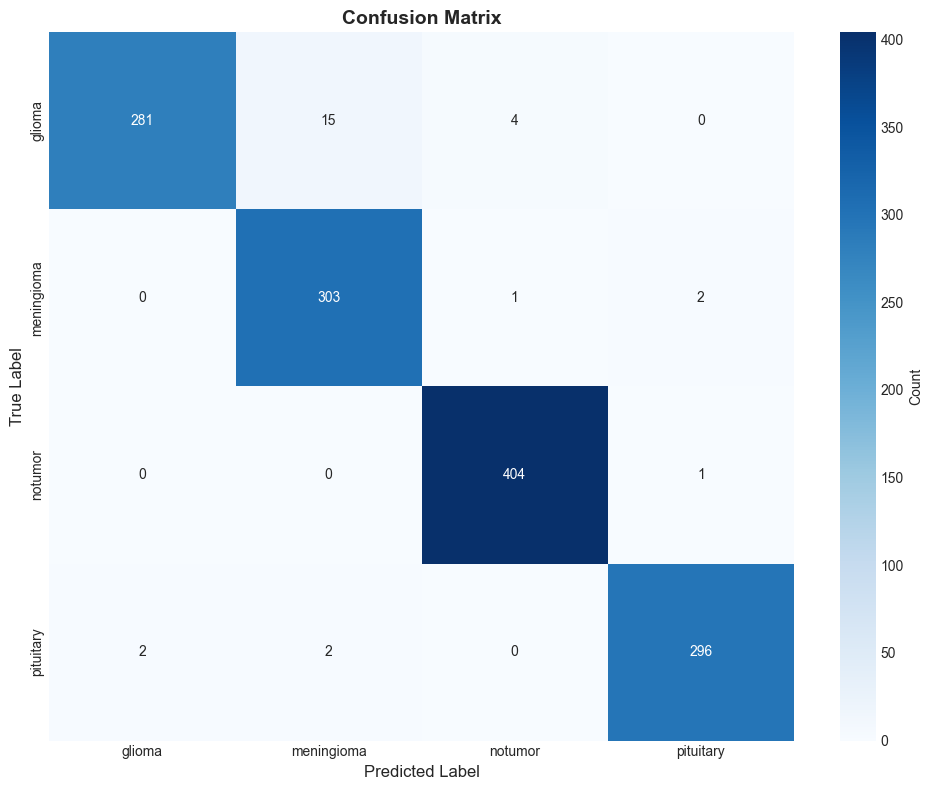

Confusion matrix saved to: ..\outputs\confusion_matrix.png


In [15]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion matrix saved to: {OUTPUT_DIR / 'confusion_matrix.png'}")

## 16. Classification Report

In [16]:
# Generate classification report
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("Classification Report:")
print("="*60)
print(report)

# Get report as dictionary for saving
report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

Classification Report:
              precision    recall  f1-score   support

      glioma     0.9929    0.9367    0.9640       300
  meningioma     0.9469    0.9902    0.9681       306
     notumor     0.9878    0.9975    0.9926       405
   pituitary     0.9900    0.9867    0.9883       300

    accuracy                         0.9794      1311
   macro avg     0.9794    0.9778    0.9782      1311
weighted avg     0.9799    0.9794    0.9793      1311



## 17. Save Metrics to JSON

In [17]:
# Prepare metrics dictionary
metrics = {
    'model': 'ResNet18',
    'num_epochs': CONFIG['num_epochs'],
    'batch_size': CONFIG['batch_size'],
    'learning_rate': CONFIG['learning_rate'],
    'best_epoch': checkpoint['epoch'],
    'best_val_accuracy': float(checkpoint['val_acc']),
    'best_val_loss': float(checkpoint['val_loss']),
    'final_train_accuracy': float(history['train_acc'][-1]),
    'final_train_loss': float(history['train_loss'][-1]),
    'test_accuracy': float(accuracy_score(all_labels, all_preds)),
    'class_names': class_names,
    'num_classes': num_classes,
    'classification_report': report_dict,
    'training_history': {
        'train_loss': [float(x) for x in history['train_loss']],
        'train_acc': [float(x) for x in history['train_acc']],
        'val_loss': [float(x) for x in history['val_loss']],
        'val_acc': [float(x) for x in history['val_acc']]
    },
    'confusion_matrix': cm.tolist()
}

# Save to JSON
metrics_path = OUTPUT_DIR / CONFIG['metrics_name']
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=4)

print(f"\nMetrics saved to: {metrics_path}")
print(f"\nFinal Test Accuracy: {metrics['test_accuracy']*100:.2f}%")


Metrics saved to: ..\outputs\metrics.json

Final Test Accuracy: 97.94%


## 18. Visualize Sample Predictions

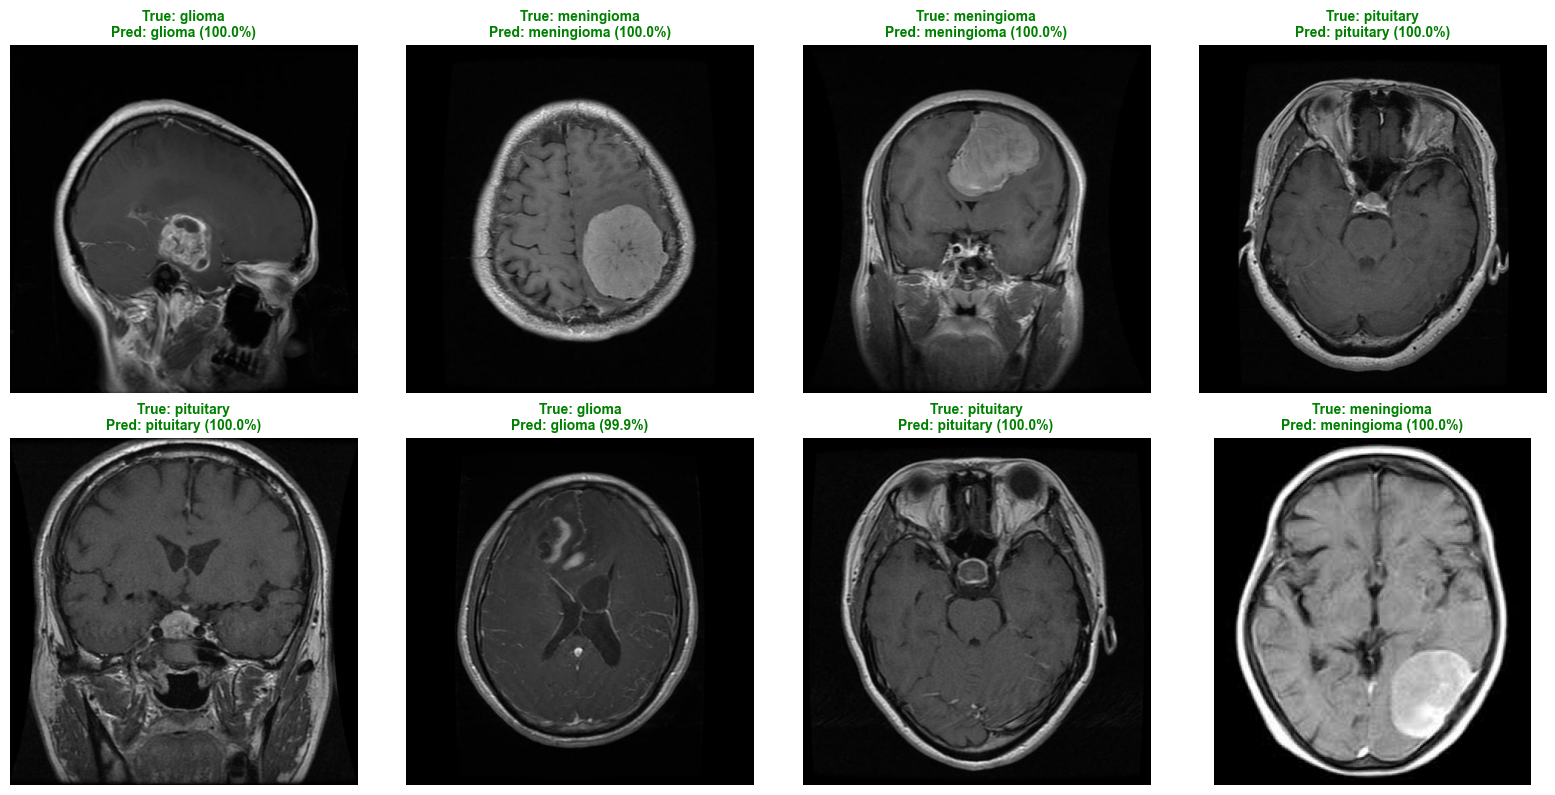

Sample predictions saved to: ..\outputs\sample_predictions.png


In [18]:
# Visualize some predictions
def visualize_predictions(model, dataset, device, num_samples=8):
    """Visualize sample predictions"""
    model.eval()
    
    # Get random samples
    indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for idx, sample_idx in enumerate(indices):
        img_path, true_label = dataset.samples[sample_idx]
        img_pil = Image.open(img_path).convert('RGB')
        img_tensor = dataset.transform(img_pil).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(img_tensor)
            probs = torch.softmax(output, dim=1)
            pred_prob, pred_label = torch.max(probs, 1)
        
        pred_class = class_names[pred_label.item()]
        true_class = class_names[true_label]
        confidence = pred_prob.item() * 100
        
        # Display image
        axes[idx].imshow(img_pil)
        axes[idx].axis('off')
        
        # Set title with prediction
        color = 'green' if pred_label.item() == true_label else 'red'
        title = f'True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)'
        axes[idx].set_title(title, fontsize=10, color=color, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions(model, test_dataset, device)
print(f"Sample predictions saved to: {OUTPUT_DIR / 'sample_predictions.png'}")

## 19. Summary

In [19]:
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Model: ResNet18 (pretrained)")
print(f"Device: {device}")
print(f"Classes: {', '.join(class_names)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(test_dataset)}")
print(f"Epochs trained: {CONFIG['num_epochs']}")
print(f"Best epoch: {checkpoint['epoch']}")
print(f"Best validation accuracy: {checkpoint['val_acc']*100:.2f}%")
print(f"Test accuracy: {metrics['test_accuracy']*100:.2f}%")
print(f"\nModel saved to: {best_model_path}")
print(f"Metrics saved to: {metrics_path}")
print("="*60)
print("\n✓ Training complete! You can now use the model in the Streamlit app.")
print("  Run: streamlit run app/app.py")
print("="*60)


TRAINING SUMMARY
Model: ResNet18 (pretrained)
Device: cuda
Classes: glioma, meningioma, notumor, pituitary
Training samples: 5712
Validation samples: 1311
Epochs trained: 10
Best epoch: 8
Best validation accuracy: 97.94%
Test accuracy: 97.94%

Model saved to: ..\models\tumor_model.pth
Metrics saved to: ..\outputs\metrics.json

✓ Training complete! You can now use the model in the Streamlit app.
  Run: streamlit run app/app.py
